In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import os
import seaborn as sns
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import statsmodels.stats.multitest as ss
from scipy import stats
import matplotlib.gridspec as gs

## Functions for analysis

In [2]:
def calc_rho_pval(summed_count_df, method = 'Bonferroni'):
    out_rho = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )
    out_pval = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )

    for j in summed_count_df.columns:
        for i in summed_count_df.columns:
            dd = summed_count_df[[i,j]].dropna()
            rho, pval =stats.spearmanr(dd[i], dd[j])
            if i==j:
                out_rho.loc[i, j] = 1
                out_pval.loc[i, j] = 0
            else:
                out_rho.loc[i, j] = rho;
                out_pval.loc[i,j] = pval;
    out_bonfe = pd.DataFrame(out_pval.unstack())
    a, b ,c, d = ss.multipletests(pd.DataFrame(out_pval.unstack())[0], method=method)
    out_bonfe[0]=b
    out_bonfe = out_bonfe.reset_index().pivot(columns='level_0', index='level_1', values=0)
    return(out_rho, out_pval, out_bonfe)

def cluster_map_bonfe(rhodf, pvaldf, figname='figures/cluster.pdf',
                      cutoff=0.05, col_colors=None, row_colors=None, symbol='*', vmin=-1, vmax=1):
    cluster = sns.clustermap(rhodf.fillna(0), col_colors=col_colors, row_colors=row_colors,yticklabels=1, 
                         metric='braycurtis',
                 vmin=vmin, vmax=vmax, cmap=sns.color_palette("icefire", as_cmap=True),
                  xticklabels =1,)
    posx_dict={}
    for i in np.array(cluster.ax_heatmap.get_xticklabels()):
        posx_dict[i.get_text()] = i.get_position()[0]
    posy_dict={}
    for i in np.array(cluster.ax_heatmap.get_yticklabels()):
        posy_dict[i.get_text()] = i.get_position()[1]

    sig_map = pvaldf<cutoff
    sig_map.index = sig_map.index.map(posy_dict)
    sig_map.columns = sig_map.columns.map(posx_dict)
    x =[]
    y = []
    for i in sig_map.index:
        for c in sig_map.columns:
            if sig_map.loc[i,c]==True:
                x.append(c)
                y.append(i)
    ax = cluster.ax_heatmap
    ax.scatter(x,y, marker=symbol, color='white', s=2)

    plt.savefig(figname)

In [3]:
#Read in MAG data
HQ_Mags=pd.read_csv(os.path.join("..","input","eukulele_mmseqs_joined_tax.csv")).\
        merge(pd.read_csv(os.path.join("..","input","eukulele_mmseqs_joined_tax_sarahgroups.csv")),how="left")

HQ_Mags["Genome"]=HQ_Mags["new_mag_name"]
translation_dict = pd.read_csv(os.path.join("..","input",'renamed-eukaryotic-mags.tsv'), sep='\t')
busco_completeness = pd.read_csv(os.path.join("..","input","EUK_BUSCO_CC.csv")).\
    merge(translation_dict,left_on="Unnamed: 0",right_on="old_mag_name")
#HQ_Mags = HQ_Mags.merge(busco_completeness,left_on="new_mag_name",right_on="new_mag_name")
#HQ_Mags[HQ_Mags.Completeness>=0]
HQ_Mags=HQ_Mags.merge(pd.read_csv(os.path.join("..","input","taxonomy-colors.csv")),
                                                           left_on="sarah_groups",
                                                           right_on="tax_group")

EukMAGDF = pd.read_csv(os.path.join("..","input","TableS2_EukaryoticMAG.csv"), index_col=0)
translation_dict = pd.read_csv(os.path.join("..","input",'renamed-eukaryotic-mags.tsv'),
                               sep='\t', index_col=0).to_dict()['new_mag_name']
translation_dict_r = pd.read_csv(os.path.join("..","input",'renamed-eukaryotic-mags.tsv'),
                                 sep='\t', index_col=1).to_dict()['old_mag_name']
HQ_Mags.index = HQ_Mags["new_mag_name"]
#HQ_Mags.index = HQ_Mags.index.map(translation_dict)
EukMAGDF['total_length_Mb'] = EukMAGDF.total_length/10**6

EukMAGDF_HQ = EukMAGDF.merge(HQ_Mags, left_index=True, right_index=True)

In [4]:
translation_dict_r["TOPAZ_SAS3_E002"]

'SAO-all-SRF-20-180-00_bin-2'

In [5]:
EukMAGDF_HQ[EukMAGDF_HQ.tax_group=="Alveolata"]

,eukulele_taxonomy,mmseqs_taxonomy,groups,total_length,total_num_contigs,total_length_5kb,total_length_10kb,total_length_50kb,GC_percent,N50,...,Family_mmseqs,Genus_mmseqs,Species_mmseqs,region,depth_y,size_fraction_y,sarah_groups,Genome,tax_group,color
TOPAZ_IOS3_E007,Eukaryota;Alveolata;Ciliophora;Spirotrichea;-;...,Eukaryota;-;Sar;Ciliophora;Spirotrichea;Choreo...,SAR,5651603,1701,557510,20859,0,46.26,3197,...,Rhabdonellidae,Schmidingerella,Schmidingerella taraikaensis,IO-all,SRF,20-180-00,Alveolata,TOPAZ_IOS3_E007,Alveolata,#62CBB2
TOPAZ_IOS3_E008,Eukaryota;Alveolata;Ciliophora;Spirotrichea;-;...,Eukaryota;-;Sar;Ciliophora;Spirotrichea;Choreo...,SAR,2949253,929,135660,0,0,48.62,3086,...,Rhabdonellidae,Schmidingerella,Schmidingerella taraikaensis,IO-all,SRF,20-180-00,Alveolata,TOPAZ_IOS3_E008,Alveolata,#62CBB2
TOPAZ_SAS3_E002,Eukaryota;Alveolata;Ciliophora;Spirotrichea;-;...,Eukaryota;-;Sar;Ciliophora;Spirotrichea;Choreo...,SAR,5103573,1320,1336247,128899,0,49.12,3851,...,Rhabdonellidae,Schmidingerella,Schmidingerella taraikaensis,SAO-all,SRF,20-180-00,Alveolata,TOPAZ_SAS3_E002,Alveolata,#62CBB2
TOPAZ_SPS3_E015,Eukaryota;Alveolata;Ciliophora;Spirotrichea;-;...,Eukaryota;-;Sar;Ciliophora;Spirotrichea;Choreo...,SAR,6677580,1803,1525042,217792,0,44.20,3580,...,Rhabdonellidae,Schmidingerella,Schmidingerella taraikaensis,SPO-SPSG,SRF,20-180-00,Alveolata,TOPAZ_SPS3_E015,Alveolata,#62CBB2
TOPAZ_SPS3_E062,Eukaryota;Alveolata;Ciliophora;Spirotrichea;-;...,Eukaryota;-;Sar;Ciliophora;Spirotrichea;Choreo...,SAR,6287932,1698,1507187,200972,0,44.18,3543,...,Rhabdonellidae,Schmidingerella,Schmidingerella taraikaensis,SPO-all,SRF,20-180-00,Alveolata,TOPAZ_SPS3_E062,Alveolata,#62CBB2
TOPAZ_SPS3_E078,Eukaryota;Alveolata;Ciliophora;Spirotrichea;-;...,Eukaryota;-;Sar;Ciliophora;Spirotrichea;Choreo...,SAR,3650178,940,973427,0,0,48.45,3889,...,Oxytrichidae,Schmidingerella,Schmidingerella taraikaensis,SPO-all,SRF,20-180-00,Alveolata,TOPAZ_SPS3_E078,Alveolata,#62CBB2


In [6]:
trophy_df = pd.read_csv(os.path.join('..','input','trophy_data.csv'), index_col=0)
trophy_df.index = trophy_df.index.map(translation_dict)
trophy_df = trophy_df.merge(EukMAGDF_HQ['sarah_groups'], left_index=True, right_index=True)


In [7]:
#Read in the trophic data
trophy_df = pd.read_csv(os.path.join('..','input','trophy_data.csv'), index_col=0)
trophy_df.index = trophy_df.index.map(translation_dict)
trophy_df = trophy_df.merge(EukMAGDF_HQ['sarah_groups'], left_index=True, right_index=True)

#read in metagenomic abundance
tpm_df = pd.read_csv(os.path.join("..","input","MAG_tpm_new_approach.csv"),index_col=0)
tpm_df.index=tpm_df.Genome
tpm_df=tpm_df.drop("Genome",axis=1)
tpm_df = tpm_df.loc[list(set(EukMAGDF_HQ.index).intersection(set(tpm_df.index)))]

#Read in pangea data
pangea = pd.read_csv(os.path.join('..','input','TARA_sample_enviro.tab'), sep ='\t', header=2508, index_col=0)
ena_table = pd.read_csv(os.path.join('..','input','PRJEB4352_metaG.txt'), sep='\t')
ena_data = ena_table.merge(pangea, left_on='sample_alias', right_index=True) 
ena_data= ena_data.set_index('run_accession')
errdf = pd.read_csv(os.path.join('..','input','SampleList_2020_metaG.txt'), sep='\t')
errnewdf = pd.DataFrame(columns=errdf.columns)
for i in errdf.index:
    E = errdf.loc[i, 'ERR_list'].split(', ')
    for e in E:
        if e in errnewdf.index:
            pass
        else:
            errnewdf.loc[e]=errdf.loc[i]
errnewdf['depth'] = errnewdf.Depth_sizefrac.str.split('-').str[0]
errnewdf['sf'] = errnewdf.Depth_sizefrac.str.split('-').str[1:].str.join('-')

tax_colors=pd.read_csv(os.path.join("..","input","taxonomy-colors.csv"))
het_col = {'Phototroph':'#b4cc3d', 'Heterotroph':'#cc3d6d', 
           'Metazoa': list(tax_colors.color[tax_colors.tax_group=="Metazoa"])[0]}

In [8]:
order = ['Metazoa', 'Apusozoa','Choanozoa','Amoebozoa','Fungi','SAR','Dinoflagellata',
         'Ochrophyta','Chlorophyta', 'Cryptophyta',  'Haptophyta']#,'Alveolata','Eukaryota']

/vortexfs1/home/akrinos/.conda/envs/EUKulele/envs/cartopy/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 13.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/vortexfs1/home/akrinos/.conda/envs/EUKulele/envs/cartopy/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/vortexfs1/home/akrinos/.conda/envs/EUKulele/envs/cartopy/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


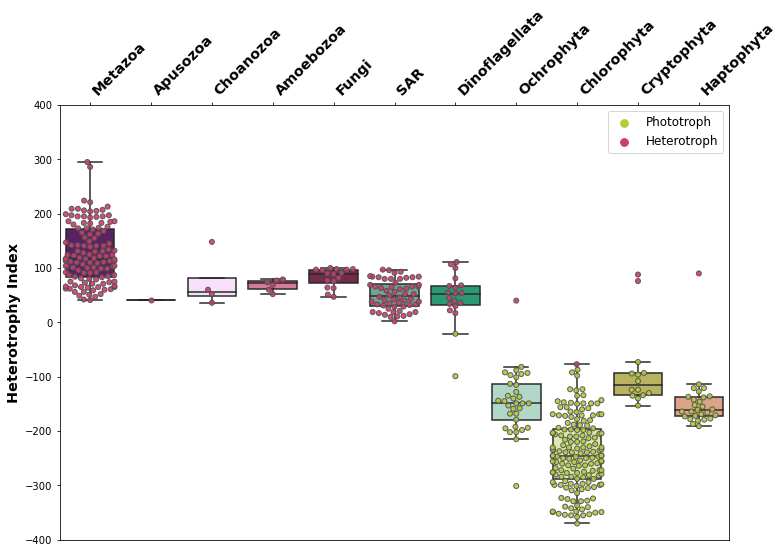

In [9]:
flierprops = {'marker':'o', 'alpha':0.5, 'markersize':0}
cdict=dict(zip(tax_colors.tax_group,tax_colors.color))
cdict["SAR"]="#6EAA93"
fig, ax = plt.subplots(1, figsize=[12,8])

sns.boxplot(data = trophy_df, x='sarah_groups', y='HeterotrophyScore', palette=cdict,
            ax=ax,order=order, flierprops=flierprops, )
sns.swarmplot(data = trophy_df, x='sarah_groups', y='HeterotrophyScore',
             ax=ax, order=order, size=5, hue='PredictedTrophicMode', 
              palette=het_col, alpha=0.9, linewidth=1, edgecolor='gray')
ax.set_ylabel('Heterotrophy Index', fontsize='x-large', fontweight = 'bold')
ax.set_xlabel('')
ax.xaxis.set_tick_params(labeltop='on',)
ax.xaxis.tick_top()

ax.set_xticklabels(order, rotation=45, ha='left', fontsize='x-large', fontweight='bold')
ax.legend(fontsize='large')
ax.set_ylim([-400, 400])
plt.savefig('../figures/trophy-group_cluster.pdf')

In [29]:
trophy_df['PredictedTrophicModeMet'] = trophy_df.PredictedTrophicMode
meta = trophy_df[trophy_df.sarah_groups=='Metazoa'].index
trophy_df.loc[meta,'PredictedTrophicModeMet']='Metazoa'
trophy_tpm_merged = trophy_df.merge(tpm_df, left_index=True, right_index=True)
trophy_tpm_merged = trophy_tpm_merged.groupby('PredictedTrophicModeMet').sum()[tpm_df.columns].T
trophy_tpm_merged = trophy_tpm_merged.merge(ena_data, left_index=True, right_index=True)
trophy_tpm_merged = trophy_tpm_merged.merge(errnewdf, left_index=True, right_index=True)

In [30]:
cols = [ 'Heterotroph','Phototroph', 'Metazoa'
, 'Depth ref [m] (in the selected environmental...)',
 'Sal (in the selected environmental...)',
 'Tpot [°C] (in the selected environmental...)',
 'Sigma-theta [kg/m**3] (in the selected environmental...)',
 'O2 [µmol/kg] (in the selected environmental...)',
 '[PO4]3- [µmol/l] (in the selected environmental...)',
 '[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)',
 'Si(OH)4 [µmol/l] (in the selected environmental...)',
 'Chl a [mg/m**3] (in the selected environmental...)',
 'bbp470 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (in the selected environmental...)',
 'bacp660 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (at the sampling location, exp...)',
 'PAR day [mol quanta/m**2/day] (for a period of 8 days around...)',
 'NPP C [mg/m**2/day] (for a period of 8 days around...)',
 'MLD [m] (in the selected environmental...)',
 'D chl m [m] (in the selected environmental...)',
 'Depth max Brunt Väisälä freq [m] (in the selected environmental...)',
 'Depth max O2 [m] (in the selected environmental...)',
 'Depth nitracline [m] (in the selected environmental...)',
 'SSD [min] (day length)',
 "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
 "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
 'OW (indicates the presence of an ...)',
 'MLE [1/day] (indicates the presence of a t...)',
 "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
 'RT [days] (of the water mass. Values>30 ...)',
]

In [31]:
def draw_pie(dist, 
             xpos, 
             ypos, 
             size, cartopy=True,
             ax=None, colors=['blue', 'red'], alpha=0.8):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    if cartopy:
        for r1, r2, c in zip(pie[:-1], pie[1:], colors):
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()

            xy = np.column_stack([x, y])

            ax.scatter([xpos], [ypos], marker=xy, s=size, transform=ccrs.PlateCarree(), color=c, alpha=alpha)
    else:
        for r1, r2 in zip(pie[:-1], pie[1:]):
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()

            xy = np.column_stack([x, y])

            ax.scatter([xpos], [ypos], marker=xy, s=size,)

    return ax
def plot_maps_overlay_sf(df, scale = 10e-5*2, ax=None, depth = 'SRF'):
    sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(1, 4)

    for i, s in enumerate(sf):
        sdf = df[(df['sf']==s) & (df['depth']==depth)]
        ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, color = 'gray')
        
        for i in sdf.index:
            
            draw_pie([sdf.loc[i,'Heterotroph'],sdf.loc[i,'Metazoa'],sdf.loc[i,'Phototroph']], 
                     xpos =sdf.loc[i,'Longitude'], ypos=sdf.loc[i,'Latitude'],
                     size=sdf.loc[i,['Heterotroph', 'Phototroph', 'Metazoa']].sum()*scale, cartopy=True, ax=ax, 
                     colors=[het_col['Heterotroph'], het_col['Metazoa'],het_col['Phototroph']])
        ax.set_title(s, fontsize='x-large', fontweight='bold')
        ax.set_extent([-180, 110, -80, 70], crs=ccrs.PlateCarree())
    legend_sizes = [1e4,5e4, 1e5,5e5]
    for i in legend_sizes:
        ax.scatter(x=0, y=0, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
    ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
#         ax.scatter(x =df.Longitude, y=df.Latitude, 
#                s= df[c]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=het_col[c])
    

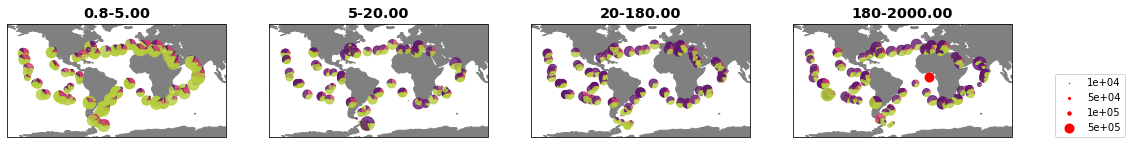

In [32]:
plot_maps_overlay_sf(trophy_tpm_merged, depth='SRF')
plt.savefig('../figures/SRF-het-prot-map.pdf')

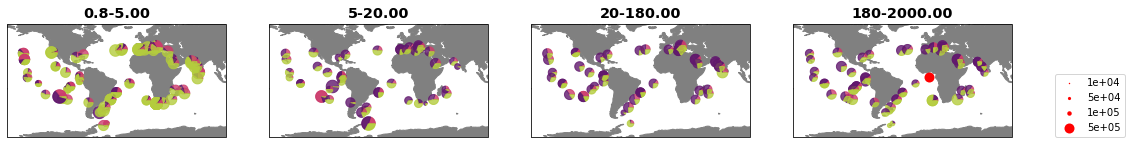

In [33]:
plot_maps_overlay_sf(trophy_tpm_merged, depth='DCM')
plt.savefig('../figures/DCM-het-prot-map.pdf')

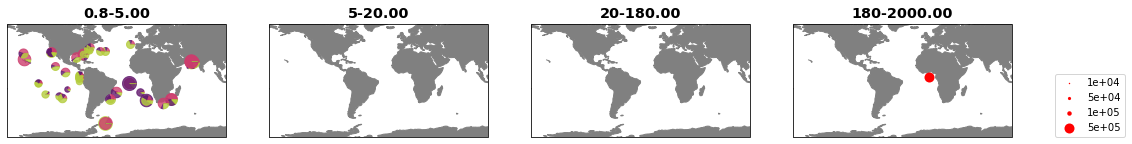

In [34]:
plot_maps_overlay_sf(trophy_tpm_merged, depth='MES')
plt.savefig('../figures/MES-het-prot-map.pdf')

In [35]:
out_rho, out_pval, out_bonfe = calc_rho_pval(trophy_tpm_merged[cols])


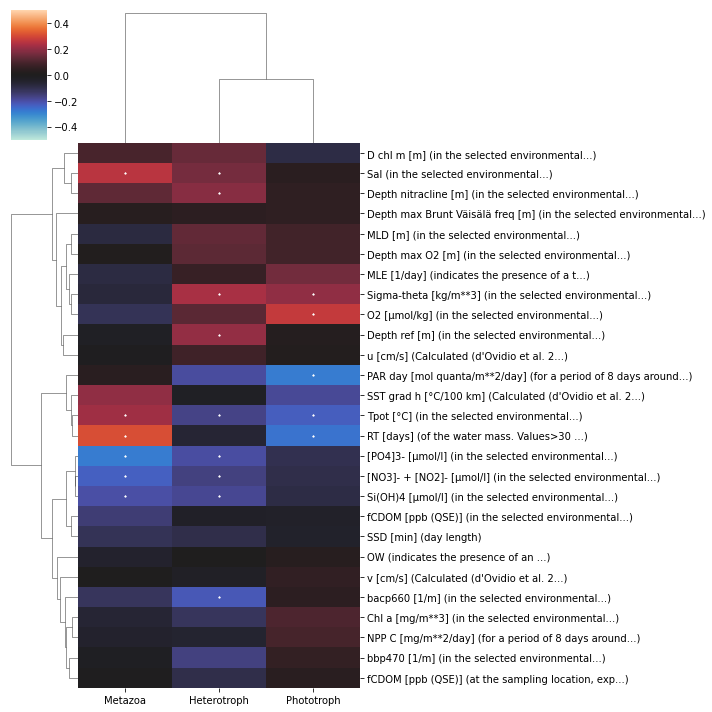

In [36]:
i = ['Heterotroph','Phototroph', 'Metazoa']
cluster_map_bonfe(out_rho.fillna(0)[i].drop(i), out_bonfe.fillna(1)[i].drop(i), figname='../figures/trophy-env-cluster.pdf', cutoff=0.01
                 , vmin=-.5, vmax=.5)

In [37]:
#tpm_df = pd.read_csv('../data/MAG_tpm.csv', index_col=0)
tpm_df = pd.read_csv(os.path.join("..","input","MAG_tpm_new_approach.csv"),index_col=0)
tpm_df.index=tpm_df.Genome
tpm_df=tpm_df.drop(["Genome"],axis=1)
networks = pd.read_csv('/vortexfs1/omics/alexander/share/2022-03-25_mags_communities/all_mags_communities.csv')

m1 = networks['mag']
networks['ALLMAGS']=m1

MAG_dict = networks[['community', 'ALLMAGS']].set_index('ALLMAGS')['community'].to_dict()
nd = networks[['ALLMAGS', 'community']].set_index('ALLMAGS')

community_tpm = tpm_df.merge(nd, left_index=True, right_index=True).groupby('community').sum().T

community_tpm = community_tpm.merge(ena_data, left_index=True, right_index=True)
community_tpm = community_tpm.merge(errnewdf, left_index=True, right_index=True)

In [38]:
def plot_maps_overlay_test(df,community, gs, scale = 10e-4, ax=None, depth = 'SRF', color='pink'):
    sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]

    for i, s in enumerate(sf):
        sdf = df[(df['sf']==s) & (df['depth']==depth)]
        ax = fig.add_subplot(gs[community-1, i], projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, color = 'gray')
        ax.scatter(sdf['Longitude'], sdf['Latitude'], s=sdf[community]*scale, transform=ccrs.PlateCarree(), color=color, alpha=.8)
#         for i in sdf.index:
            
#             draw_pie([sdf.loc[i,'Heterotroph'],sdf.loc[i,'Metazoa'],sdf.loc[i,'Phototroph']], 
#                      xpos =sdf.loc[i,'Longitude'], ypos=sdf.loc[i,'Latitude'],
#                      size=sdf.loc[i,['Heterotroph', 'Phototroph', 'Metazoa']].sum()*scale, cartopy=True, ax=ax, 
#                      colors=[het_col['Heterotroph'], het_col['Metazoa'],het_col['Phototroph']])
        
        if community==1:
            ax.set_title(s, fontsize='x-large', fontweight='bold')
        ax.set_extent([-180, 110, -80, 70], crs=ccrs.PlateCarree())
    if community==1:
        
        legend_sizes = [1e4,5e4, 1e5,5e5]
        for i in legend_sizes:
            ax.scatter(x=0, y=0, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
        ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)


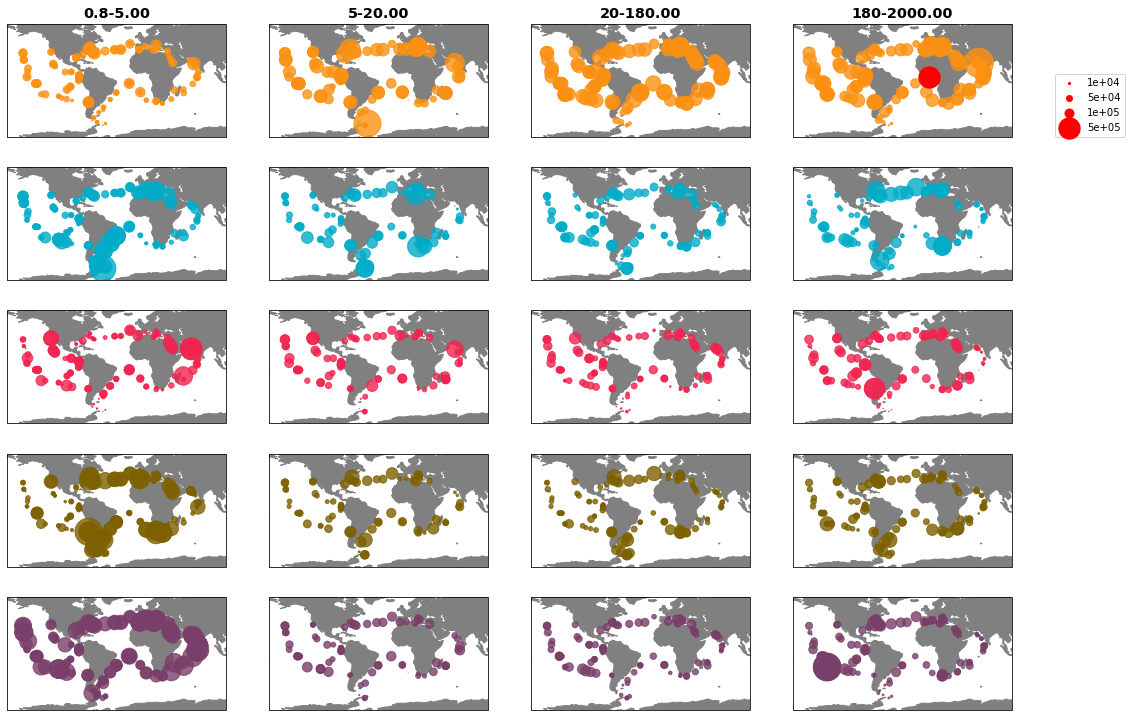

In [39]:
fig = plt.figure(figsize=(18, 18))
gs = fig.add_gridspec(7, 4)
colors = ['#fb9113','#01acc8','#f12450', '#7d6100','#793e69','#a54d00', '#f2bb95']
for i in range(1,6):#8):
    plot_maps_overlay_test(community_tpm, community=i, gs = gs, scale=10e-4, color=colors[i-1])
fig.savefig('../figures/Network_community_maps-02.pdf')
fig.savefig('../figures/Network_community_maps-02.png')